In [ ]:
# Other sources
# https://thecleverprogrammer.com/2022/07/12/stock-market-analysis-using-python/
# https://blog.quantinsti.com/asset-beta-market-beta-python/
# https://plainenglish.io/blog/measure-stock-volatility-using-betas-in-python-d6411612e7bd
# https://medium.com/@polanitzer/building-a-dcf-valuation-in-python-step-by-step-9ba686e0b3a
# https://github.com/wilsonfreitas/awesome-quant


In [ ]:
# !pip install highcharts-stock

In [ ]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Importing python package pandas datareader to import data from yahoo and stooq
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()


In [ ]:
start_date = '2019-01-01'
end_date = '2023-04-23'
# Importing data
aapl = pdr.get_data_stooq("AAPL", start=start_date, end=end_date)
tsla = pdr.get_data_stooq("TSLA", start=start_date, end=end_date)

# for stooq
# Indices are prefixed by ^ e.g. ^DJI (Dow Jones Industrial), ^UK100 (FTSE100)
# US stocks are suffixed by .US e.g. AAPL.US, MSFT.US, TSLA.US
# Cryptocurrencies are suffixed by .V e.g. BTC.V (BitCoin)
# PL stocks are suffixed by .PL e.g. CDR.PL (CD Projekt)
# Price/Earnings are suffixed by _PE.US e.g. AAPL_PE.US

cdr = pdr.get_data_stooq('CDR.PL', start=start_date, end=end_date)

In [ ]:
# Time for some inspections
# TBD na warsztacie
tsla


,Open,High,Low,Close,Volume
Date,,,,,
2023-04-21,164.8000,166.0000,161.3208,165.0800,123538954
2023-04-20,166.1650,169.7000,160.5600,162.9900,210970819
2023-04-19,179.1000,183.5000,177.6500,180.5900,125732687
2023-04-18,187.1500,187.6900,183.5775,184.3100,92067016
2023-04-17,186.3200,189.6900,182.6900,187.0400,116662189
...,...,...,...,...,...
2019-01-08,22.7973,22.9340,21.8013,22.3567,105127740
2019-01-07,21.4480,22.4493,21.1833,22.3307,113268375
2019-01-04,20.4000,21.2000,20.1820,21.1793,110911740


In [ ]:
# Adding all dataframes into a dictionary, so we can loop over:

stocks = {
    'aapl': aapl,
    'tsla': tsla,
    'cdr':  cdr
}


# Looping over dict items -> for key, value in dict.items():...
for name, df in stocks.items():
    # Basic data cleaning techniques (e.g. removing null values)
    df = df.dropna()

    # Calculating daily returns
    df["Daily Return"] = df["Close"].pct_change()

    # Calculating basic financial metrics (e.g. moving averages)
    # Calculating the 50d and 200d simple moving average
    df["SMA50"] = df["Close"].rolling(window=50).mean()
    df["SMA200"] = df["Close"].rolling(window=200).mean()
    # Overwriting old dataframe in stocks dictionary
    stocks[name] = df





In [ ]:
df = stocks['tsla']

# Plotting
# Create subplots and mention plot grid size
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
               vertical_spacing=0.1, subplot_titles=('OHLC', 'Volume'), 
               row_width=[0.2, 0.7])

# Plot OHLC on 1st row
fig.add_trace(go.Candlestick(x=df.index, open=df["Open"], high=df["High"],
                low=df["Low"], close=df["Close"], name="Price"), 
                row=1, col=1
)

# Plot MAs on 1st row
fig.add_trace(go.Scatter(x=df.index, y=df['SMA50'], name='50d SMA', line={'color':'blue'}), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['SMA200'], name='200d SMA', line={'color':'yellow'}), row=1, col=1)

# Bar trace for volumes on 2nd row without legend
fig.add_trace(go.Bar(x=df.index, y=df['Volume'], showlegend=False), row=2, col=1)

# Do not show OHLC's rangeslider plot 
fig.update(layout_xaxis_rangeslider_visible=False)

# Do not show weekends
fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"]), #hide weekends
        dict(values=["2015-12-25", "2016-01-01"])  # hide Christmas and New Year's
    ]
)

# Log scale for Y-axis
# fig.update_yaxes(type="log", row=1, col=1)

fig.show()
del(fig)

In [ ]:
# Calculate beta
# Importing libraries and packages
import statsmodels.api as sm
from statsmodels import regression



return_tsla = stocks['tsla']["Daily Return"][1:]
spy = pdr.get_data_stooq("SPY.US", start=start_date, end=end_date)
return_spy = spy['Close'].pct_change()[1:]

# Regression model
X = return_spy.values
Y = return_tsla.values

def linreg(x,y):
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()

    # We are removing the constant
    x = x[:, 1]
    return model.params[0], model.params[1]

alpha, beta = linreg(X,Y)
print('alpha: ' + str(alpha))
print('beta: ' + str(beta))

<ipython-input-33-729310af8000>:6: UserWarning:

Legend does not support handles for Axes instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries



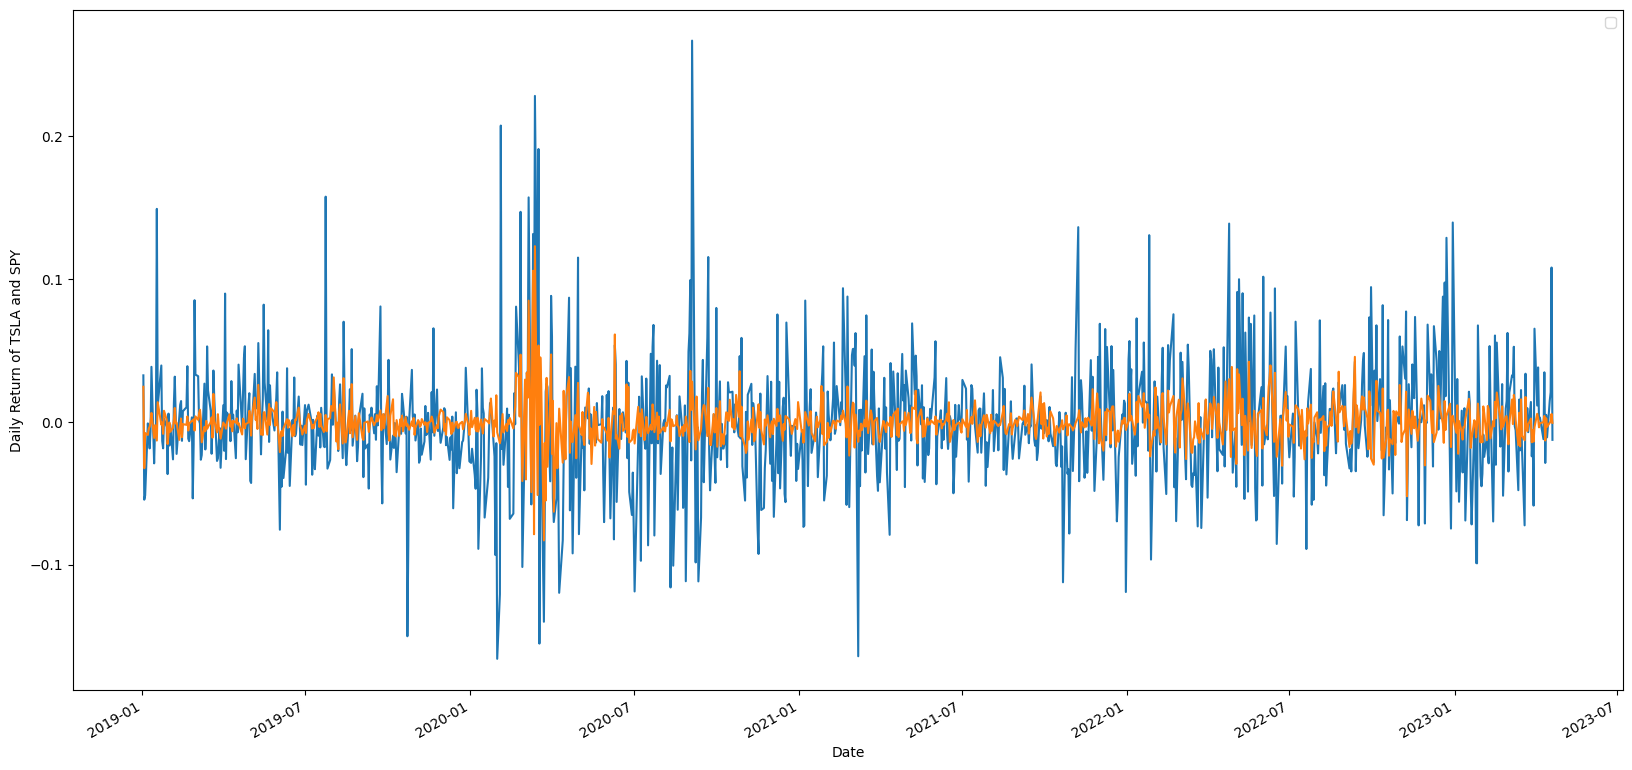

In [ ]:
# We will plot the returns of Google and S&P500 against each other
plt.figure(figsize=(20,10))
tsla_plot = return_tsla.plot()
spy_plot = return_spy.plot()
plt.ylabel("Daily Return of TSLA and SPY")
plt.legend(['TSLA', 'SPY'])
plt.show()


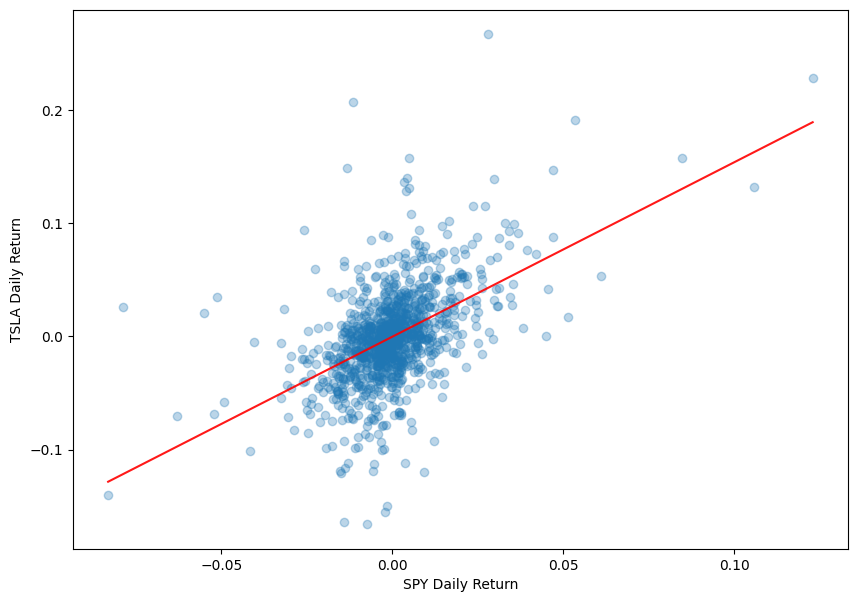

In [ ]:
# Plotting beta
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * beta + alpha
plt.figure(figsize=(10,7))
plt.scatter(X, Y, alpha=0.3) # Plot the raw data
plt.xlabel("SPY Daily Return")
plt.ylabel("TSLA Daily Return")
plt.plot(X2, Y_hat, 'r', alpha=0.9)
plt.show()